In [52]:

import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from fancyimpute import IterativeImputer, KNN

# Load datasets
df_sales = pd.read_csv('umsatzdaten_gekuerzt.csv')
df_test = pd.read_csv('test.csv')
df_weather = pd.read_csv('wetter.csv')
df_kiwo = pd.read_csv('kiwo.csv')
df_holidays = pd.read_csv('Feiertage.csv')
df_tourismus = pd.read_csv("tourismus_sh_monate_filled.csv", sep=";")

# Concatenate df_test at the bottom of df_sales
df_sales = pd.concat([df_sales, df_test], axis=0, ignore_index=True)

# Print shape before and after concatenation
print("Shape of merged dataframe:", df_sales.shape)
print("Date range:", df_sales['Datum'].min(), "to", df_sales['Datum'].max())

print(df_sales.head())  


Shape of merged dataframe: (11164, 4)
Date range: 2013-07-01 to 2019-07-30
        Datum  Warengruppe      Umsatz  id
0  2013-07-01            1  148.828353 NaN
1  2013-07-02            1  159.793757 NaN
2  2013-07-03            1  111.885594 NaN
3  2013-07-04            1  168.864941 NaN
4  2013-07-05            1  171.280754 NaN


Imputing row 1/2601 with 0 missing, elapsed time: 0.321
Imputing row 101/2601 with 0 missing, elapsed time: 0.322
Imputing row 201/2601 with 0 missing, elapsed time: 0.323
Imputing row 301/2601 with 0 missing, elapsed time: 0.323
Imputing row 401/2601 with 1 missing, elapsed time: 0.324
Imputing row 501/2601 with 0 missing, elapsed time: 0.324
Imputing row 601/2601 with 0 missing, elapsed time: 0.325
Imputing row 701/2601 with 1 missing, elapsed time: 0.325
Imputing row 801/2601 with 0 missing, elapsed time: 0.326
Imputing row 901/2601 with 0 missing, elapsed time: 0.327
Imputing row 1001/2601 with 0 missing, elapsed time: 0.327
Imputing row 1101/2601 with 1 missing, elapsed time: 0.327
Imputing row 1201/2601 with 0 missing, elapsed time: 0.328
Imputing row 1301/2601 with 0 missing, elapsed time: 0.328
Imputing row 1401/2601 with 1 missing, elapsed time: 0.329
Imputing row 1501/2601 with 0 missing, elapsed time: 0.329
Imputing row 1601/2601 with 0 missing, elapsed time: 0.330
Imputing 

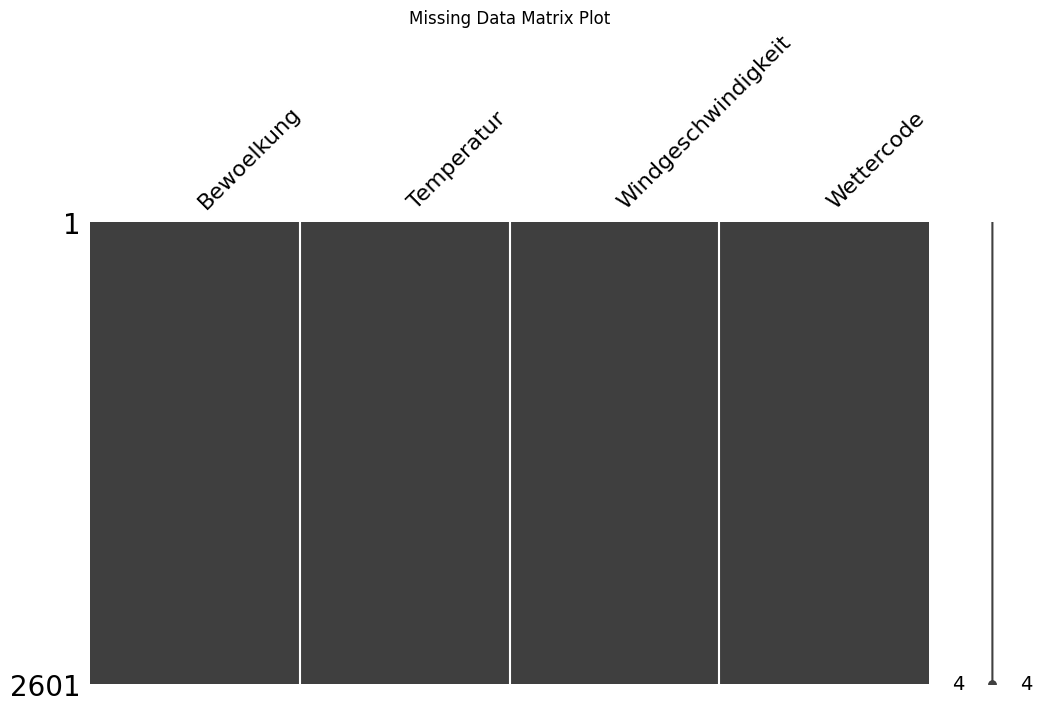

In [53]:
# KNN imputation
numerical_columns = df_weather.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = df_weather.select_dtypes(include=['object']).columns

# Store original values for comparison
original_values = df_weather[numerical_columns].copy()

# Perform KNN imputation
imputer_knn = KNN(k=1)
df_weather_imputed = pd.DataFrame(imputer_knn.fit_transform(df_weather[numerical_columns]), columns=numerical_columns)

# Replace missing values in df_weather with imputed values
df_weather[numerical_columns] = df_weather_imputed

# Visualize missing data
msno.matrix(df_weather_imputed, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

In [54]:
# Merge sales and weather data
df_merged = pd.merge(df_sales, df_weather, on='Datum', how='left')

# Merge with Kieler Woche data
df_merged_with_kiwo = pd.merge(df_merged, df_kiwo, on='Datum', how='left')

# Define weather codes that indicate precipitation, snow, or wet conditions
rain_weather_codes = [
    # Rain related codes
    50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
    60, 61, 62, 63, 64, 65, 66, 67,
    80,81,82,91,92,95,97
]

snow_weather_codes = [
    # Snow related codes
    36,37,38,39,
    68,69,70,71,72,73,74,75,76,77,78,79,
    83,84,85,86,87,88,89,90,93,94,95,96,97,99

]


# Create dry_weather column (1 for dry, 0 for wet)
df_merged_with_kiwo['rain_weather'] = df_merged_with_kiwo['Wettercode'].apply(lambda x: 1 if x in rain_weather_codes else 0)
df_merged_with_kiwo['snow_weather'] = df_merged_with_kiwo['Wettercode'].apply(lambda x: 1 if x in snow_weather_codes else 0)

# Fill missing values in KielerWoche column with 0
df_merged_with_kiwo['KielerWoche'] = df_merged_with_kiwo['KielerWoche'].fillna(0)

# Prepare holidays data
df_holidays['Feiertag'] = 1

# Merge with Feiertag data
df_final = pd.merge(df_merged_with_kiwo, df_holidays, on='Datum', how='left')
df_final['Feiertag'] = df_final['Feiertag'].fillna(0)

month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

# Stefan Temperatur nach Jahreszeit in ranges einteilen: kalt normal warm
def analyze_seasons(df):
    # Add season column based on month
    df['Season'] = pd.to_datetime(df['Datum']).dt.month.map(month_to_season)

    # Group by season and calculate min/max temperature
    seasonal_stats = df.groupby('Season')['Temperatur'].agg(['min', 'max'])
    
    return seasonal_stats

# Analyze seasons and add season column to df_final
seasonal_stats = analyze_seasons(df_final)
print(seasonal_stats)

# Add season column to df_final
df_final['Season'] = pd.to_datetime(df_final['Datum']).dt.month.map(month_to_season)

# Function to categorize temperature into bins based on season
def categorize_temperature(row, seasonal_stats):
    season = row['Season']
    temp = row['Temperatur']
    min_temp = seasonal_stats.loc[season, 'min']
    max_temp = seasonal_stats.loc[season, 'max']
    bins = pd.cut([min_temp, max_temp], bins=3, retbins=True)[1]
    temp_bins = pd.cut([temp], bins=bins, labels=['low', 'middle', 'high'])
    return f"{season}_{temp_bins[0]}"

# Apply the function to create a new column in df_final
df_final['Season_Temp_Category'] = df_final.apply(lambda row: categorize_temperature(row, seasonal_stats), axis=1)

# Apply one hot encoding for Season_Temp_Category with 0 and 1
df_final = pd.concat([df_final, pd.get_dummies(df_final['Season_Temp_Category'], prefix='Season_Temp', drop_first=False)], axis=1)

# Add month column to df_final based on Datum
german_months = {
    1: 'Januar',
    2: 'Februar',
    3: 'März',
    4: 'April',
    5: 'Mai',
    6: 'Juni',
    7: 'Juli',
    8: 'August',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Dezember'
}

df_final['Monat'] = pd.to_datetime(df_final['Datum']).dt.month.map(german_months)

# Add Jahr column to df_final based on Datum
df_final['Jahr'] = pd.to_datetime(df_final['Datum']).dt.year.astype('int32')

# Merge with tourismus data
# Left merge df_final with df_tourismus based on Jahr and Monat
df_final = pd.merge(df_final, df_tourismus[['Jahr', 'Monat', 'Ankuenfte', 'Uebernachtungen']], 
                    on=['Jahr', 'Monat'], 
                    how='left')

print(df_final[['Datum','Warengruppe','Jahr', 'Monat', 'Uebernachtungen']].head(10))

# Print min and max dates
min_date = df_final['Datum'].min()
max_date = df_final['Datum'].max()
print(f"Min Datum: {min_date}")
print(f"Max Datum: {max_date}")

            min        max
Season                    
Fall     0.0000  27.875000
Spring  -4.9625  26.862500
Summer  11.5625  32.671428
Winter  -8.4750  13.412500
        Datum  Warengruppe  Jahr Monat  Uebernachtungen
0  2013-07-01            1  2013  Juli          4421298
1  2013-07-02            1  2013  Juli          4421298
2  2013-07-03            1  2013  Juli          4421298
3  2013-07-04            1  2013  Juli          4421298
4  2013-07-05            1  2013  Juli          4421298
5  2013-07-06            1  2013  Juli          4421298
6  2013-07-07            1  2013  Juli          4421298
7  2013-07-08            1  2013  Juli          4421298
8  2013-07-09            1  2013  Juli          4421298
9  2013-07-10            1  2013  Juli          4421298
Min Datum: 2013-07-01
Max Datum: 2019-07-30


In [55]:
print(df_final.isna().sum())

Datum                           0
Warengruppe                     0
Umsatz                       1830
id                           9334
Bewoelkung                     81
Temperatur                     81
Windgeschwindigkeit            81
Wettercode                     81
KielerWoche                     0
rain_weather                    0
snow_weather                    0
Feiertag                        0
Jahr                            0
Season                          0
Season_Temp_Category            0
Season_Temp_Fall_high           0
Season_Temp_Fall_low            0
Season_Temp_Fall_middle         0
Season_Temp_Fall_nan            0
Season_Temp_Spring_high         0
Season_Temp_Spring_low          0
Season_Temp_Spring_middle       0
Season_Temp_Spring_nan          0
Season_Temp_Summer_high         0
Season_Temp_Summer_low          0
Season_Temp_Summer_middle       0
Season_Temp_Winter_high         0
Season_Temp_Winter_low          0
Season_Temp_Winter_middle       0
Season_Temp_Wi

In [56]:
# Add a column to df_final that gives the day of the week for each date in the Datum column
df_final['Wochentag'] = pd.to_datetime(df_final['Datum']).dt.day_name()

# Create a dummy variable for weekends (1 for Saturday and Sunday, 0 otherwise)
df_final['is_weekend'] = df_final['Wochentag'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Create dummy variables for each day of the week and drop one to avoid multicollinearity
df_final = pd.concat([df_final, pd.get_dummies(df_final['Wochentag'], drop_first=True)], axis=1)

# get one hot ecoding for Warengruppe
df_final = pd.concat([df_final, pd.get_dummies(df_final['Warengruppe'], prefix='Warengruppe', drop_first=False)], axis=1)

print(df_final.columns) 


Index(['Datum', 'Warengruppe', 'Umsatz', 'id', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'rain_weather',
       'snow_weather', 'Feiertag', 'Jahr', 'Season', 'Season_Temp_Category',
       'Season_Temp_Fall_high', 'Season_Temp_Fall_low',
       'Season_Temp_Fall_middle', 'Season_Temp_Fall_nan',
       'Season_Temp_Spring_high', 'Season_Temp_Spring_low',
       'Season_Temp_Spring_middle', 'Season_Temp_Spring_nan',
       'Season_Temp_Summer_high', 'Season_Temp_Summer_low',
       'Season_Temp_Summer_middle', 'Season_Temp_Winter_high',
       'Season_Temp_Winter_low', 'Season_Temp_Winter_middle',
       'Season_Temp_Winter_nan', 'Monat', 'Ankuenfte', 'Uebernachtungen',
       'Wochentag', 'is_weekend', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'Warengruppe_1', 'Warengruppe_2',
       'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6'],
      dtype='object')


In [57]:


selected_columns = ['Datum', 'Umsatz', 'KielerWoche', 'rain_weather', 'snow_weather', 'Feiertag',
                    'Season_Temp_Fall_low', 'Season_Temp_Fall_middle', 'Ankuenfte', 'Uebernachtungen',
                    'Season_Temp_Spring_high', 'Season_Temp_Spring_low', 'Season_Temp_Spring_middle',
                    'Season_Temp_Summer_high', 'Season_Temp_Summer_low', 'Season_Temp_Summer_middle',
                    'Season_Temp_Winter_high', 'Season_Temp_Winter_low', 'Season_Temp_Winter_middle', 'Monday',
                    'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday',
                    'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6']

df_subset = df_final[selected_columns]


In [58]:
# Convert boolean columns to integers
df_subset = df_subset.copy()
for col in df_subset.select_dtypes(include=['bool']):
    df_subset[col] = df_subset[col].astype(int)

print(df_subset.head())

        Datum      Umsatz  KielerWoche  rain_weather  snow_weather  Feiertag  \
0  2013-07-01  148.828353          0.0             0             0       0.0   
1  2013-07-02  159.793757          0.0             0             0       0.0   
2  2013-07-03  111.885594          0.0             1             0       0.0   
3  2013-07-04  168.864941          0.0             0             0       0.0   
4  2013-07-05  171.280754          0.0             0             0       0.0   

   Season_Temp_Fall_low  Season_Temp_Fall_middle  Ankuenfte  Uebernachtungen  \
0                     0                        0     963277          4421298   
1                     0                        0     963277          4421298   
2                     0                        0     963277          4421298   
3                     0                        0     963277          4421298   
4                     0                        0     963277          4421298   

   ...  Tuesday  Wednesday  Thursday  

In [59]:
# Split dataset into training and validation sets
train_df = df_subset[(df_subset['Datum'] >= '2013-07-01') & (df_subset['Datum'] <= '2017-07-31')]
validation_df = df_subset[(df_subset['Datum'] >= '2017-08-01') & (df_subset['Datum'] <= '2018-07-31')]
test_df = df_subset[(df_subset['Datum'] >= '2018-08-01') & (df_subset['Datum'] <= '2018-12-31')]


# export train_df and validation_df as csv
train_df.to_csv('train_df.csv', index=False)
validation_df.to_csv('validation_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

print(f"Training set: {train_df.shape[0]} rows")
print(f"Validation set: {validation_df.shape[0]} rows")
print(f"Test set: {test_df.shape[0]} rows")

Training set: 7493 rows
Validation set: 1841 rows
Test set: 805 rows
